# A Particular Infection: Exploring the spread of the discovery of the Higgs boson via contagion modeling

Data made available by the Stanford Network Analysis Project (SNAP) [here](http://snap.stanford.edu/data/higgs-twitter.html).

## Setup

### Imports

In [112]:
import collections
from datetime import datetime, timedelta
import math

import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

### Graph utility functions

In [113]:
def describe_graph(name, graph):
    print(f'Graph: {name}')
    print(f' - nodes: {graph.vcount()}')
    print(f' - edges: {graph.ecount()}')
    print(f' - avg. clustering coefficient: {graph.transitivity_undirected()}')
    print(f' - assortativity coefficient: {graph.assortativity_degree()}')
    
def initialize_graph(graph, infected_nodes):
    if not isinstance(infected_nodes, list):
        infected_nodes = [infected_nodes]
    
    missing = np.setdiff1d(infected_nodes, graph.vs['name'])
    graph.vs['state'] = 's'
    intersect_infected_nodes = np.intersect1d(infected_nodes, graph.vs['name'])
    set_nodes_state(graph, intersect_infected_nodes, 'i')
    return graph
    
def igraph_from_dataframe(df, source_index, target_index):
    return ig.Graph.TupleList([(x[source_index], x[target_index]) for x in df.values], directed=True)

def init_infection_vector(graph, infected_node_names):
    infections = np.full(graph.vcount(), 's')
    
    for infected_node in infected_node_names:
        infected_node_index = graph.vs.find(infected_node).index
        infections[infected_node_index] = 'i'
        
    return infections

def infect_vector(infection_vector, indices):
    for index in indices:
        infection_vector[index] = 'i'
    
    return infection_vector

def infect_vector_by_names(graph, infection_vector, names):
    for name in names:
        vertex = graph.vs.find(name)
        infection_vector[vertex.index] = 'i'
    
    return infection_vector

def get_state_count(infection_vector, state):
    return np.count_nonzero(infection_vector == state)

def find_idx_nearest_value(array, value):
    array = np.asarray(array)
    # https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    return (np.abs(array - value)).argmin()

### Plotting

In [114]:
def make_scatter(x, y, title, x_label='', y_label='', log_xscale=False, log_yscale=False):
    figure, axes = plt.subplots()
    axes.scatter(x, y)
    axes.set_title(title)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    
    if log_xscale:
        axes.set_xscale('log')
    if log_yscale:
        axes.set_yscale('log')
    
    return figure

def plot_scenario(df, title='', columns=['infected_pct', 'susceptible_pct'], figsize=None):
    if figsize is not None:
        plt.figure(figsize=figsize)
    ax = sns.lineplot(data=df[columns])
    ax.set_title(title)
    ax.set_xlabel('t (time)')
    ax.set_ylabel('Proportion of nodes infected')

## Preprocessing

### Retweets graph

In [22]:
df_interactions = pd.read_csv('./data/higgs-activity_time.txt', delim_whitespace=True, header=None)
df_interactions.columns = ['user', 'target_user', 'timestamp', 'interaction_type']
df_retweets = df_interactions.query('interaction_type == "RT"')
df_retweets['user'] = df_retweets['user'].astype(str)
df_retweets['target_user'] = df_retweets['target_user'].astype(str)
df_retweets['date'] = df_retweets['timestamp'].apply(datetime.fromtimestamp)
df_retweets = df_retweets.drop(['interaction_type', 'timestamp'], axis='columns')
df_retweets.columns = ['user', 'retweeted_user', 'date']
df_retweets.sort_values(by=['date'])

# make a note of the user who first retweeted the event - we use them as ground zero in multiple scenarios
first_infected_user = df_retweets.iloc[0]['retweeted_user']

df_retweets.head()

,user,retweeted_user,date
2,376989,50329,2012-06-30 20:06:21
4,376989,13813,2012-06-30 20:06:32
5,453850,8,2012-06-30 20:06:48
7,99258,50329,2012-06-30 20:07:43
12,75083,84647,2012-06-30 20:15:32


In [23]:
graph_retweets = igraph_from_dataframe(df_retweets, 1, 0)

### Followers graph

In [8]:
df_followers = pd.read_csv('./data/higgs-social_network.edgelist', delim_whitespace=True, header=None)
df_followers.columns = ['user', 'followed_user']
df_followers['user'] = df_followers['user'].astype(str)
df_followers['followed_user'] = df_followers['followed_user'].astype(str)
df_followers.head()

,user,followed_user
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


In [9]:
graph_followers = igraph_from_dataframe(df_followers, 1, 0)

## General Exploration

In [57]:
describe_graph('Retweets', graph_retweets)
describe_graph('Followers', graph_followers)

Graph: Retweets
 - nodes: 256491
 - edges: 354930
 - avg. clustering coefficient: 0.0003255645136484373
 - assortativity coefficient: 0.054873965388226364
Graph: Followers
 - nodes: 456626
 - edges: 14855842
 - avg. clustering coefficient: 0.008652186742072765
 - assortativity coefficient: -0.1375472477145811


### Degree distribution

In [111]:
god_vertex = graph_retweets.vs.find(_degree_gt=graph_retweets.maxdegree(mode=ig.OUT))
god_vertex_name = god_vertex['name']
print(god_vertex_name)
print(df_retweets.query('retweeted_user == @god_vertex_name').shape)
print(df_retweets.query('retweeted_user == @god_vertex_name & date >= "07/03/2012"').shape)

88
(18977, 3)
(18665, 3)


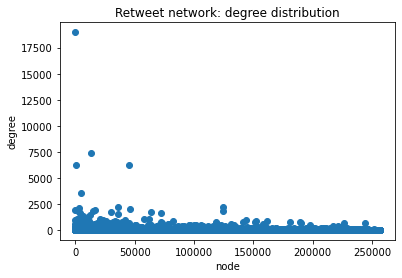

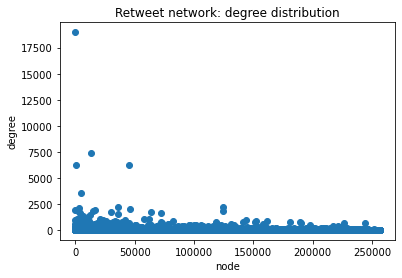

In [107]:
make_scatter(range(graph_retweets.vcount()), graph_retweets.degree(mode=ig.OUT), title='Retweet network: degree distribution', x_label='node', y_label='degree')

## Ground truth: actual retweet contagion

In [25]:
if False: # to guard against running against this accidentally, it takes a bit
    log = False
    df_retweets_si = pd.DataFrame()
    infections = init_infection_vector(graph_retweets, [first_infected_user])
    
    max_date = df_retweets['date'].max()
    min_date = df_retweets['date'].min()

    total_minutes = math.ceil((max_date - min_date).total_seconds() / 60)
    total_nodes = graph_retweets.vcount()

    for minute in range(total_minutes):
        window_min = min_date + timedelta(minutes=minute)
        window_max = min_date + timedelta(minutes=minute+1)
        df_min = df_retweets.query('date >= @window_min & date < @window_max')

        window_infected_nodes = list(df_min['user'].unique())
        
        if len(window_infected_nodes) > 0:
            infect_vector_by_names(graph_retweets, infections, window_infected_nodes)

        snapshot = {
            't': minute,
            'normalized_t': minute / total_minutes,
            'susceptible_pct': get_state_count(infections, 's') / total_nodes,
            'infected_pct': get_state_count(infections, 'i') / total_nodes
        }
        
        if minute % 500 == 0 and log:
            print(snapshot)

        df_retweets_si = df_retweets_si.append(snapshot, ignore_index=True)
        
            
    df_retweets_si.set_index('t', inplace=True)
    df_retweets_si.head()

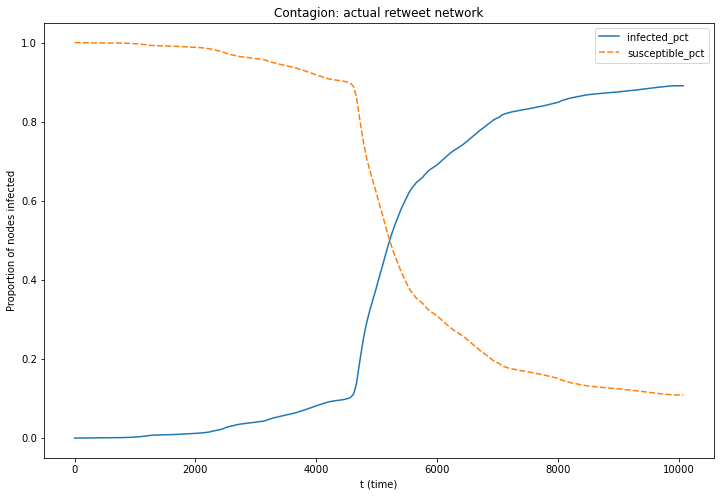

In [27]:
plot_scenario(df_retweets_si, 'Contagion: actual retweet network', figsize=(12,8))

## Contagion Modeling

In [14]:
def run_sim_optim(graph, infected_nodes=[], m0=1, max_t=100, beta=None, contagion_type='simple_homogenous', log=False):
    print('Initializing...')
    df = pd.DataFrame()
    total_node_count = graph.vcount()
    infection_vector = init_infection_vector(graph, infected_nodes)
    print ('Starting sim.')
    
    for t in range(max_t):
        if log:
            print('Starting', t)
        node_indices_to_infect = []
        
        if contagion_type == 'simple_homogenous':
            for index, state in enumerate(infection_vector):
                if state == 's' and np.random.uniform() < beta:
                    node_indices_to_infect.append(index)
                    
        elif contagion_type == 'simple_heterogeneous':
            for index, state in enumerate(infection_vector):
                if state == 's':
                    neighbors = graph.predecessors(graph.vs[index])
                    for neighbor in neighbors:
                        if infection_vector[neighbor] == 'i' and np.random.uniform() <= beta:
                            node_indices_to_infect.append(index)
        
        elif contagion_type == 'complex':
            for index, state in enumerate(infection_vector):
                if state == 's':
                    neighbors = graph.predecessors(graph.vs[index])
                    total_neighbors = len(neighbors)
                    infected_neighbors = 0
                    
                    if total_neighbors == 0:
                        continue
                    
                    for neighbor in neighbors:
                        if infection_vector[neighbor] == 'i':
                            infected_neighbors += 1
                            
                    if np.random.uniform() < infected_neighbors / total_neighbors:
                        node_indices_to_infect.append(index)
                    
        # infect new nodes
        infect_vector(infection_vector, node_indices_to_infect)
        
        # build snapshot and append
        snapshot = { 't': t, 'susceptible_pct': get_state_count(infection_vector, 's') / total_node_count , 'infected_pct': get_state_count(infection_vector, 'i') / total_node_count }
        if log:
            print(snapshot)
        df = df.append(snapshot, ignore_index=True)
    
    df.set_index('t', inplace=True)
    return df

### Simple contagion model: SI with variable $\beta$

Initializing...
Starting sim.


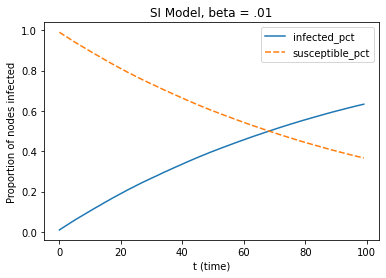

In [38]:
df_scenario_si_b01 = run_sim_optim(graph_retweets, infected_nodes=[first_infected_user], beta=.01)
plot_scenario(df_scenario_si_b01, 'SI Model, beta = .01')

Initializing...
Starting sim.


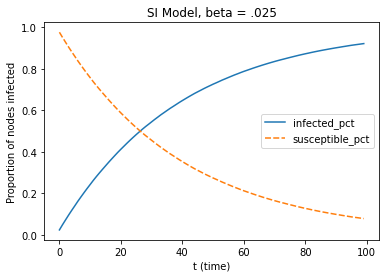

In [39]:
df_scenario_si_b025 = run_sim_optim(graph_retweets, infected_nodes=[first_infected_user], beta=.025)
plot_scenario(df_scenario_si_b025, 'SI Model, beta = .025')

Initializing...
Starting sim.


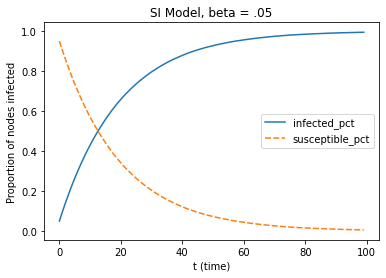

In [40]:
df_scenario_si_b05 = run_sim_optim(graph_retweets, infected_nodes=[first_infected_user], beta=.05)
plot_scenario(df_scenario_si_b05, 'SI Model, beta = .05')

Initializing...
Starting sim.


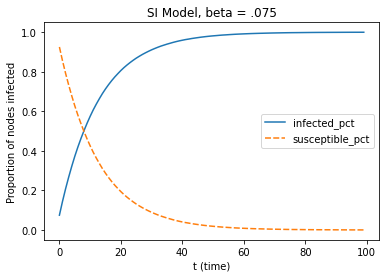

In [41]:
df_scenario_si_b075 = run_sim_optim(graph_retweets, infected_nodes=[first_infected_user], beta=.075)
plot_scenario(df_scenario_si_b075, 'SI Model, beta = .075')

#### All homogenous SI models

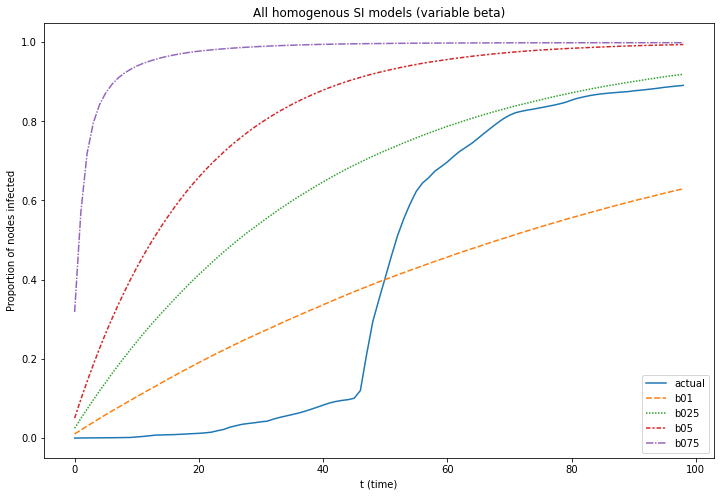

In [42]:
df_scenario_homo_all = pd.DataFrame({ 't': range(0,99)})
df_scenario_homo_all['actual'] = df_scenario_homo_all['t'].apply(lambda x: df_retweets_si.iloc[find_idx_nearest_value(df_retweets_si['normalized_t'], x/100)]['infected_pct'])
df_scenario_homo_all['b01'] = df_scenario_si_b01['infected_pct']
df_scenario_homo_all['b025'] = df_scenario_si_b025['infected_pct']
df_scenario_homo_all['b05'] = df_scenario_si_b05['infected_pct']
df_scenario_homo_all['b075'] = df_scenario_hetero_b075['infected_pct']
df_scenario_homo_all.set_index('t', inplace=True)
plot_scenario(df_scenario_homo_all, 'All homogenous SI models (variable beta)', columns=df_scenario_homo_all.columns, figsize=(12, 8))

### Simple SI model with heterogeneous mixing

In [45]:
simple_hetero_m0 = 100

Initializing...
Starting sim.


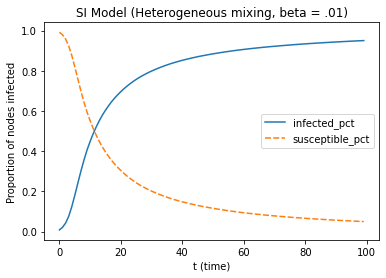

In [46]:
df_scenario_hetero_b01 = run_sim_optim(graph_followers, list(df_followers['followed_user'].head(simple_hetero_m0)), beta=.01, contagion_type='simple_heterogeneous', max_t=100)
plot_scenario(df_scenario_hetero_b01, 'SI Model (Heterogeneous mixing, beta = .01)')

Initializing...
Starting sim.


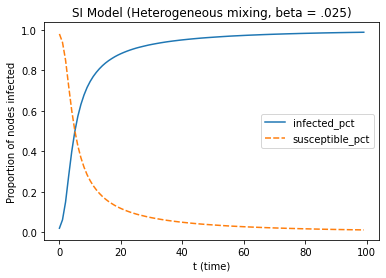

In [47]:
df_scenario_hetero_b025 = run_sim_optim(graph_followers, list(df_followers['followed_user'].head(simple_hetero_m0)), beta=.025, contagion_type='simple_heterogeneous', max_t=100)
plot_scenario(df_scenario_hetero_b025, 'SI Model (Heterogeneous mixing, beta = .025)')

Initializing...
Starting sim.


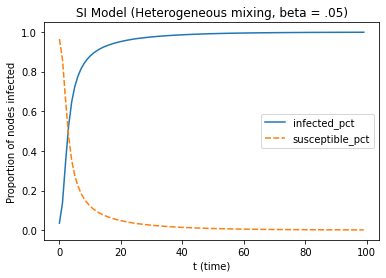

In [48]:
df_scenario_hetero_b05 = run_sim_optim(graph_followers, list(df_followers['followed_user'].head(simple_hetero_m0)), beta=.05, contagion_type='simple_heterogeneous', max_t=100)
plot_scenario(df_scenario_hetero_b05, 'SI Model (Heterogeneous mixing, beta = .05)')

Initializing...
Starting sim.


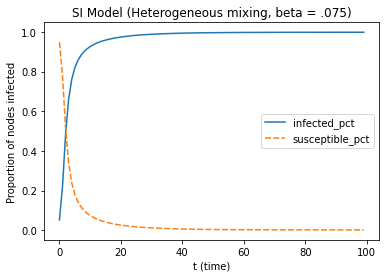

In [49]:
df_scenario_hetero_b075 = run_sim_optim(graph_followers, list(df_followers['followed_user'].head(simple_hetero_m0)), beta=.075, contagion_type='simple_heterogeneous', max_t=100)
plot_scenario(df_scenario_hetero_b075, 'SI Model (Heterogeneous mixing, beta = .075)')

#### All heterogeneous SI models

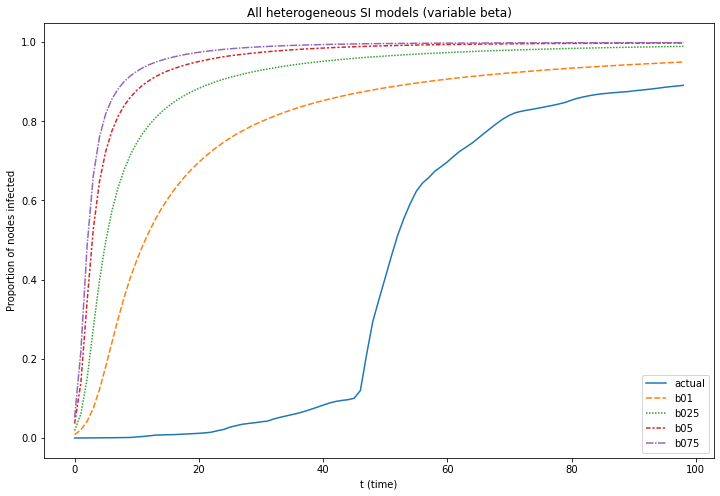

In [52]:
df_scenario_hetero_all = pd.DataFrame({ 't': range(0, 99) })
df_scenario_hetero_all['actual'] = df_scenario_hetero_all['t'].apply(lambda x: df_retweets_si.iloc[find_idx_nearest_value(df_retweets_si['normalized_t'], x/100)]['infected_pct'])
df_scenario_hetero_all['b01'] = df_scenario_hetero_b01['infected_pct']
df_scenario_hetero_all['b025'] = df_scenario_hetero_b025['infected_pct']
df_scenario_hetero_all['b05'] = df_scenario_hetero_b05['infected_pct']
df_scenario_hetero_all['b075'] = df_scenario_hetero_b075['infected_pct']
df_scenario_hetero_all.set_index('t', inplace=True)
plot_scenario(df_scenario_hetero_all, 'All heterogeneous SI models (variable beta)', columns=df_scenario_hetero_all.columns, figsize=(12, 8))

### Complex contagion model (SI states, heterogeneous mixing based on proportion of neighbors)

In [33]:
df_scenario_co = run_sim_optim(graph_followers, list(df_followers['followed_user'].head(simple_hetero_m0)), contagion_type='complex')

Initializing...
Starting sim.


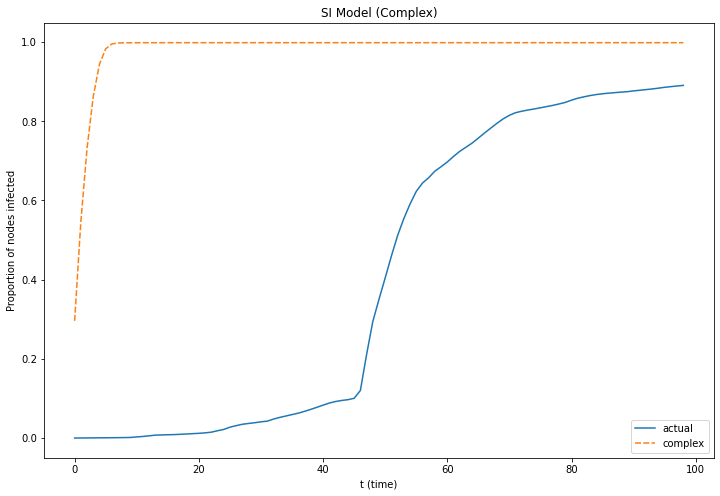

In [54]:
df_scenario_co_all = pd.DataFrame({ 't': range(0, 99) })
df_scenario_co_all['actual'] = df_scenario_co_all['t'].apply(lambda x: df_retweets_si.iloc[find_idx_nearest_value(df_retweets_si['normalized_t'], x/100)]['infected_pct'])
df_scenario_co_all['complex'] = df_scenario_co['infected_pct']
df_scenario_co_all.set_index('t', inplace=True)
plot_scenario(df_scenario_co_all, 'SI Model (Complex)', figsize=(12,8), columns=df_scenario_co_all.columns)